In [1]:
import sys, h5py, pdb,time, glob
from importlib import reload
import pylab as pl, numpy as np
from numpy import log10 as log
from astropy import units as un, constants as cons
import scipy, scipy.stats
from matplotlib import ticker
sys.path.append('../pysrc')

In [2]:
import FIRE_files as ff
from FIRE_files import cosmo, u
from projectPlotBasics import *
import first_pass as l
cmap = pl.get_cmap('viridis')

Behroozi+18 not loaded
don't have phil's colormaps


In [3]:
CF_path = '../../cooling_flow/pysrc'
sys.path.append(CF_path)
import cooling_flow as CF, HaloPotential as Halo
%matplotlib inline

In [5]:
# simname = 'vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e4_simpleSFthreshold10'
simname = 'n10_noLowCool'
vc = 200. #float(simname.split('_')[0][2:])
Rcirc = 10.# float(simname.split('_')[3][5:])
# simdir = '/projects/b1026/jonathan/my_gizmo/%s/output/'%simname
simdir = '/projects/b1026/jonathan/KY_sims/sim_outputs/%s/output/'%simname

In [7]:
sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = 10*un.kpc,snapshot_dt_Myr=10,pr=False,
              analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc*un.km/un.s,Rvir=200*un.kpc))
print(sim.galaxyname, sim.Nsnapshots())


n10_noLowCool 138


In [8]:
snapshot = sim.getSnapshot(133)

In [11]:
pl.StreamplotSet?

Object `pl.StreamplotSet` not found.


In [78]:
TCMB = 2.7 * un.K

#Planck VIII
PlanckBeamSize = 10 * un.arcmin
PlanckSensitivity = 26 * un.microKelvin * un.arcmin

#worst case scenario in Battaglia + 2017, frequency = 90-150 GHz
CMBS4_BeamSize = 1 * un.arcmin 
CMBS4Sensitivity = 1.8 * un.microKelvin * un.arcmin 

#from Bregman+2022 -- NGC891 or from stacks 
yPlanckSensitivity = 0.7e-7 
area_in_arcmin2 = np.pi*(30**2-20**2)* un.arcmin**2 #no data point for 20-30 region for some reason
# this should be unity if I understand what Bregman did
(PlanckSensitivity/area_in_arcmin2**0.5 / TCMB).to('') / yPlanckSensitivity

<Quantity 3.47097596>

In [8]:
# density from sim
0.7*5.5e-27/cons.m_p.to('g').value

0.0023017754368776055

In [80]:
dist = 8.4*un.Mpc #NGC 891
#Hodges-Kluck+18
Pth = (7e-13*un.dyn*un.cm**-2 / 2.3 / cons.k_B).to('cm**-3*K') 
T = (0.2*un.keV / cons.k_B).to('K')
Z_in_Zsun = 0.15
kpc_per_arcmin = un.arcmin.to('rad')*dist.to('kpc') / un.arcmin
size = 13.5/2*un.arcmin * kpc_per_arcmin
relative_size =size/(10*un.kpc) #relative to Rcirc from sim
NHfactor = relative_size**-0.5
res_in_kpc = CMBS4_BeamSize*kpc_per_arcmin
print(res_in_kpc,size)
d  = 5
dy = 1
binrange = binrange_x = binrange_z = np.arange(-52.5,53,d)
binrange_y = np.arange(-52.5,53,dy)
bins = binrange_x, binrange_y, binrange_z
midbin = (binrange[1:]+binrange[:-1])/2

2.443460952792061 kpc 16.493361431346415 kpc


In [19]:
coeff_kSZ = (cons.sigma_T/cons.c   * un.cm**-3 * un.km/un.s * dy *un.kpc).to('').value
coeff_tSZ = (cons.sigma_T/(cons.m_e*cons.c**2) * 2.3*un.cm**-3*cons.k_B*un.K * dy *un.kpc).to('').value
coeff_NH  = dy*un.kpc.to('cm')

In [24]:
# density from sim
print(0.7*3.5e-27/cons.m_p.to('g').value)
# density from Hodges-Kluck+18
print(Pth/T)
print(Pth/T * 15*un.kpc.to('cm'))

0.0014647661871039308
0.000949794866982235 1 / cm3
4.396141092059545e+19 1 / cm3


In [12]:
grids = scipy.stats.binned_statistic_dd(snapshot.coords(),
                                    (snapshot.vs()[:,1]*snapshot.nHs(),
                                     snapshot.Ts()*snapshot.nHs(),
                                     snapshot.nHs()),
                                    statistic='mean',
                                    bins=bins)

In [13]:
np.savez('grids_y5kpc_bins.npz',grid_kSZ=grids[0][0],grid_tSZ=grids[0][1],grid_NH=grids[0][2])

In [14]:
nu = 143*un.GHz
x = (cons.h * nu / (cons.k_B*TCMB)).to('').value
print(x,x*np.tanh(x/2)**-1 - 4)

2.541822172948974 -1.0237821415438888


In [20]:
NH  = grids[0][2].sum(axis=1).T*coeff_NH
kSZ = grids[0][0].sum(axis=1).T*coeff_kSZ
y   = grids[0][1].sum(axis=1).T*coeff_tSZ

In [135]:
mask = np.meshgrid(np.abs(midbin)<12,np.abs(midbin)<2)
# mask = np.meshgrid(np.abs(midbin)<16,np.abs(midbin)<8.7)
mask = 1-mask[0]*mask[1]
kSZ_masked = kSZ*mask
y_masked = y*mask
NH_masked = NH*mask

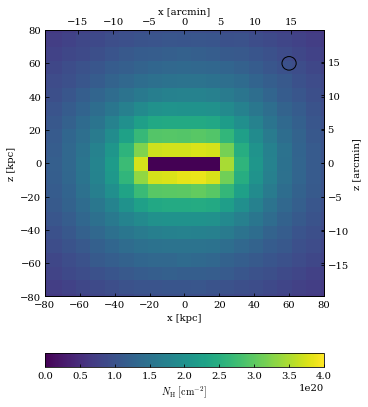

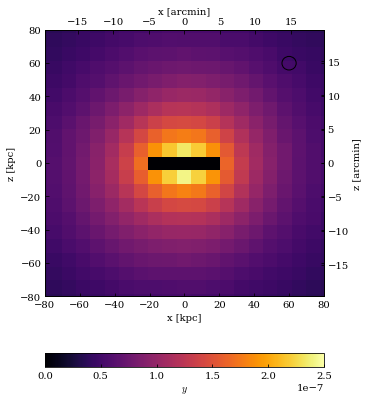

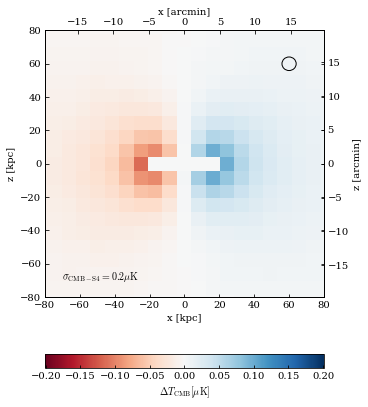

In [140]:
dist = 14*un.Mpc #double the median of Bregman's sample
kpc_per_arcmin = un.arcmin.to('rad')*dist.to('kpc') / un.arcmin
Ndisks = 10*(dist/(7*un.Mpc))**3
CMB_S4_error = CMBS4Sensitivity / CMBS4_BeamSize * Ndisks**-0.5
rng = np.array([-80,80])
inclination_factor = 2/np.pi
for i,arr in enumerate((NH_masked, y_masked, kSZ_masked*2.7/1e-6*inclination_factor)):
    label = (r'$N_{\rm H}\ [{\rm cm}^{-2}]$', r'$y$', r'$\Delta T_{\rm CMB} [\mu {\rm K}]$')[i]
    cmapname = ('viridis','inferno','RdBu')[i]
    vmin,vmax = ((0,4e20),(0,2.5e-7),(-CMB_S4_error.value,CMB_S4_error.value))[i]
    pl.figure(figsize=(5,7)); ax = pl.gca()
    pl.pcolormesh(binrange*relative_size,binrange*relative_size,arr*NHfactor,
                  cmap=pl.get_cmap(cmapname),vmin=vmin,vmax=vmax)
    cb = pl.colorbar(orientation='horizontal',label=label)
    if i==2: pl.text(-70,-70,r'$\sigma_{\rm CMB-S4}=%.1f\mu {\rm K}$'%(CMB_S4_error/un.microKelvin))
    pl.xlabel(r'x [kpc]')
    pl.ylabel(r'z [kpc]')
    pl.xlim(*rng); pl.ylim(*rng)
    ax.add_patch(pl.Circle((60,60),(CMBS4_BeamSize*kpc_per_arcmin).value,ec='k',fc='none',zorder=100))
    pl.twiny()
    pl.xlabel(r'x [arcmin]')
    pl.xlim(*(rng/kpc_per_arcmin.value))
    pl.twinx()
    pl.ylim(*(rng/kpc_per_arcmin.value))
    pl.ylabel(r'z [arcmin]')


In [137]:
pixelsPerBin

<Quantity 0.66338905>

In [138]:
sigma_arr = arr/CMB_S4_error.value
q=pl.histogram(sigma_arr.flatten(),bins=np.arange(-2.25,2.1,0.5))
print(q[0])
pixelsPerBin = (CMBS4_BeamSize*kpc_per_arcmin/(d*un.kpc))**2
print( ((sigma_arr**2).sum()/pixelsPerBin )**0.5 )

[  0   0   0  19 402  20   0   0]
3.9340150443803386


In [52]:
#stacking error in 
(np.pi*(20**2-10**2) / 2**2)**0.5

15.349900619197326

In [36]:
noise_per_pixel = (CMBS4Sensitivity/(CMBS4_BeamSize*relative_size)/TCMB).to('')
sigma = kSZ_masked / relative_size**0.5/noise_per_pixel
integer_sigma = np.round(sigma/0.5)/2


Text(0, 0.5, 'z [arcmin]')

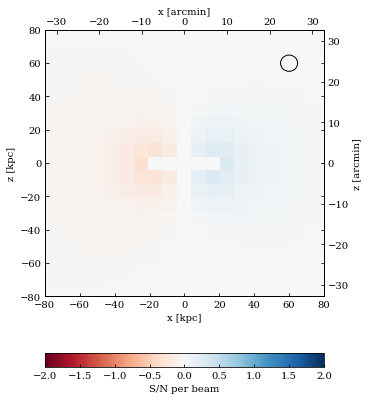

In [41]:
pl.figure(figsize=(5,7))
ax = pl.gca()
rng = np.array([-80,80])
pl.pcolormesh(binrange*relative_size,binrange*relative_size,
              sigma,vmin=-2,vmax=2,cmap=pl.get_cmap('RdBu'))
pl.colorbar(orientation='horizontal',label='S/N per beam')


In [38]:
#Total Signal
q=pl.histogram(sigma.flatten(),bins=np.arange(-2.25,2.1,0.5))
print(q[0])
print( ((sigma**2).sum())**0.5 )

[  0   0   0   4 434   3   0   0]
1.4453719832585716


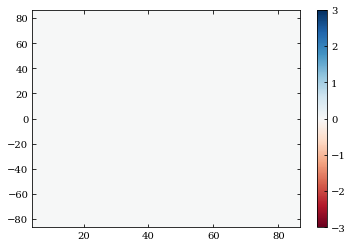

In [39]:
integer_sigma = (kSZ_masked[:,11:]-kSZ_masked[:,:10][:,::-1])/relative_size**0.5/(2**0.5*noise_per_pixel)//0.5/2 
pl.pcolormesh(binrange[11:]*relative_size,binrange*relative_size,
              integer_sigma,vmin=-3,vmax=3,cmap=pl.get_cmap('RdBu'))
pl.colorbar()

In [199]:
q=pl.histogram(integer_sigma.flatten(),bins=np.arange(-3.25,3.1,0.5))
q

(array([  0,   0,   0,   0,   0,   0, 173,  23,   9,   3,   2,   0]),
 array([-3.25, -2.75, -2.25, -1.75, -1.25, -0.75, -0.25,  0.25,  0.75,
         1.25,  1.75,  2.25,  2.75]))

In [200]:
((q[0]*(q[1][1:]+q[1][:-1])/2)**2).sum()**0.5

15.795568998931314

In [6]:
rs = []
for iSnapshot in range(20,50):
    snapshot = sim.getSnapshot(iSnapshot)
    rs.append(snapshot.rs().min())
    print(iSnapshot, len(snapshot.rs()), rs[-1])

20 5320127 0.11446050547849315
21 5310564 0.07988957818183286
22 5301267 0.09401827595303122
23 5290406 0.08271287939398554
24 5279671 0.1077744901211761
25 5268631 0.07563438970044414
26 5255380 0.10461556893091156
27 5242583 0.05174783918636867
28 5230085 0.056731785867335204
29 5217351 0.07397223561854993
30 5204609 0.0638628217027919
31 5192755 0.11426859609491313
32 5181604 0.07825737470187506
33 5171588 0.10640741747182855
34 5160823 0.09472529535080801
35 5148871 0.11230269450144288
36 5137724 0.10869572303090884
37 5126684 0.06264625211020952
38 5115736 0.1076959677444806
39 5103925 0.04761342724555018
40 5092810 0.09758531557147417
41 5081319 0.05950862908571444
42 5070179 0.11820516016237366
43 5058439 0.07880397257202228
44 5046733 0.07641175015184645
45 5035648 0.08843854094619119
46 5023488 0.09237172946357396
47 5011104 0.060861945820887615
48 4999008 0.11183538591402195
49 4986808 0.11471121989873975


In [7]:
Ps = []
for iSnapshot in range(20,50):
    snapshot = sim.getSnapshot(iSnapshot)
    ind = snapshot.rs().argmin()
    Ps.append( snapshot.nHTs()[ind] )
    print(iSnapshot, len(snapshot.rs()), Ps[-1])

20 5320127 385825.8
21 5310564 262647.44
22 5301267 421987.72
23 5290406 283986.62
24 5279671 239735.56
25 5268631 252983.5
26 5255380 447079.7
27 5242583 199888.33
28 5230085 151926.05
29 5217351 260051.53
30 5204609 203080.48
31 5192755 8658340.0
32 5181604 123207.195
33 5171588 221475.39
34 5160823 146769.3
35 5148871 375635.22
36 5137724 133000.75
37 5126684 233961.11
38 5115736 1855756.4
39 5103925 129237.65
40 5092810 5349.955
41 5081319 276296.75
42 5070179 864882.06
43 5058439 361180.97
44 5046733 409387.28
45 5035648 4308148.5
46 5023488 274263.78
47 5011104 620174.6
48 4999008 456321.7
49 4986808 212595.05


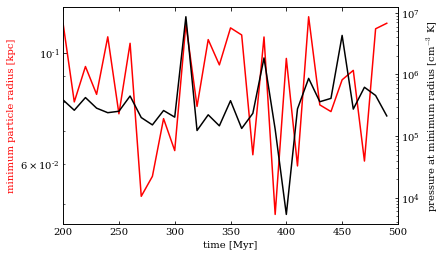

In [11]:
pl.semilogy(np.arange(20,50)*10, rs,c='r')
pl.xlabel('time [Myr]')
pl.ylabel('minimum particle radius [kpc]',color='r')
pl.twinx()
pl.semilogy(np.arange(20,50)*10, Ps,c='k')
pl.ylabel(r'pressure at minimum radius [cm$^{-3}$ K]')
pl.xlim(200,500)
pl.savefig('../figures/minimum_radius.png')

In [10]:
%matplotlib inline

In [25]:
SNeIIheating = np.genfromtxt(simdir+'SNeIIheating.txt')

In [30]:
SNeIIheating.shape

(83523, 7)

(200, 500)

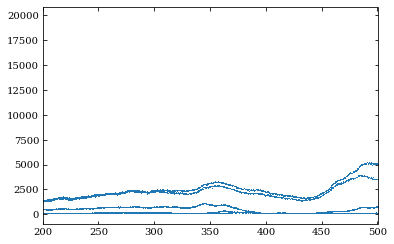

In [36]:
pl.plot(SNeIIheating[:,0]*1000,SNeIIheating[:,3],',')
pl.xlim(200,500)

In [15]:
snapshot = sim.getSnapshot(38)

In [17]:
snapshot.rs().min()

1.8785090535038151

In [14]:
reload(l)
iSnapshots = np.linspace(1,sim.Nsnapshots()-1,4).astype(int)
l.CGM_properties(sim, iSnapshots,Rcirc=10)
# pl.savefig(l.figdir+'radial_profiles_%s.pdf'%str(sim))

loaded PartType0, Masses
loaded PartType0, Coordinates
saved massProfile0
loaded PartType1, Masses
loaded PartType2, Masses
loaded PartType2, Coordinates
saved massProfile2
loaded PartType4, Masses
loaded PartType4, Coordinates
saved massProfile4
loaded PartType0, Masses
loaded PartType0, Coordinates
saved massProfile0
loaded PartType1, Masses
loaded PartType2, Masses
loaded PartType2, Coordinates
saved massProfile2
loaded PartType4, Masses
loaded PartType4, Coordinates
saved massProfile4
loaded PartType0, Masses
loaded PartType0, Coordinates
saved massProfile0
loaded PartType1, Masses
loaded PartType2, Masses
loaded PartType2, Coordinates
saved massProfile2
loaded PartType4, Masses
loaded PartType4, Coordinates
saved massProfile4
loaded PartType0, Masses
loaded PartType0, Coordinates
saved massProfile0
loaded PartType1, Masses
loaded PartType2, Masses
loaded PartType2, Coordinates
saved massProfile2
loaded PartType4, Masses
loaded PartType4, Coordinates
saved massProfile4
loaded PartT

../pysrc/FIRE_files.py:734: RuntimeWarning: invalid value encountered in true_divide
  self.save('j_vec_x'+suffix, hist[1,:] / hist[0,:])
../pysrc/FIRE_files.py:735: RuntimeWarning: invalid value encountered in true_divide
  self.save('j_vec_y'+suffix, hist[2,:] / hist[0,:])
../pysrc/FIRE_files.py:736: RuntimeWarning: invalid value encountered in true_divide
  self.save('j_vec_z'+suffix, hist[3,:] / hist[0,:])


saved j_vec_x
saved j_vec_y
saved j_vec_z
saved j_vec_weight
loaded PartType0, Velocities
saved j_vec_x
saved j_vec_y
saved j_vec_z
saved j_vec_weight
loaded PartType0, Metallicity
saved Z2Zsuns_MW
loaded PartType0, Metallicity
saved Z2Zsuns_MW
loaded PartType0, Metallicity


../pysrc/FIRE_files.py:869: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved Z2Zsuns_MW
loaded PartType0, Metallicity
saved Z2Zsuns_MW


../pysrc/FIRE_files.py:250: RuntimeWarning: overflow encountered in multiply
  if len(_masses): _masses *= 1e10/self.sim.h


loaded PartType0, Density
loaded PartType0, InternalEnergy
saved log_Ts_VW
loaded PartType0, Density
loaded PartType0, InternalEnergy
saved log_Ts_VW
loaded PartType0, Density
loaded PartType0, InternalEnergy
saved log_Ts_VW
loaded PartType0, Density
loaded PartType0, InternalEnergy
saved log_Ts_VW


../pysrc/FIRE_files.py:864: RuntimeWarning: invalid value encountered in multiply
  values = [weightvals] + [getattr(self.snapshot,attr)(*args,**kwargs)**power*weightvals for attr in new_attrs]


saved isSubsonic_VW
saved isSubsonic_VW
saved isSubsonic_VW
saved isSubsonic_VW


../pysrc/FIRE_files.py:89: RuntimeWarning: divide by zero encountered in log10
  f_H_He((log(T), log(nH))) + f_Z((log(T), log(nH))) * Z2Zsun )
/home/ysz5546/miniconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:2506: RuntimeWarning: invalid value encountered in add
  values += np.asarray(self.values[edge_indices]) * weight[vslice]
/home/ysz5546/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


saved Mdot


/home/ysz5546/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


saved Mdot


/home/ysz5546/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


saved Mdot


/home/ysz5546/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


saved Mdot


In [3]:
simname = 'vc100_Rs0_Mdot535_Rcirc10'
vc = float(simname.split('_')[0][2:])
Rcirc = float(simname.split('_')[3][5:])
simdir = '../../data/%s/output/'%simname

In [4]:
sim = l.KY_sim(simname,simdir,5e11*un.Msun,200*un.kpc,
               dynamicCentering=True,recalc=False,centerOnBlackHole=True,Nsnapshots=None,
               origin=np.zeros(3),Rcirc = Rcirc*un.kpc,
              analyticGravity= l.PowerLawPotential(m=0.,vc_Rvir=vc*un.km/un.s,Rvir=200*un.kpc))

print(sim.galaxyname, sim.Nsnapshots())

vc100_Rs0_Mdot535_Rcirc10 401


../pysrc/FIRE_files.py:89: RuntimeWarning: divide by zero encountered in log10
  f_H_He((log(T), log(nH))) + f_Z((log(T), log(nH))) * Z2Zsun )
/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:2546: RuntimeWarning: invalid value encountered in add
  values += np.asarray(self.values[edge_indices]) * weight[vslice]
../pysrc/FIRE_files.py:89: RuntimeWarning: divide by zero encountered in log10
  f_H_He((log(T), log(nH))) + f_Z((log(T), log(nH))) * Z2Zsun )
/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:2546: RuntimeWarning: invalid value encountered in add
  values += np.asarray(self.values[edge_indices]) * weight[vslice]
../pysrc/FIRE_files.py:89: RuntimeWarning: divide by zero encountered in log10
  f_H_He((log(T), log(nH))) + f_Z((log(T), log(nH))) * Z2Zsun )
/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:2546: RuntimeWarning: invalid value encountered in add
  values += np

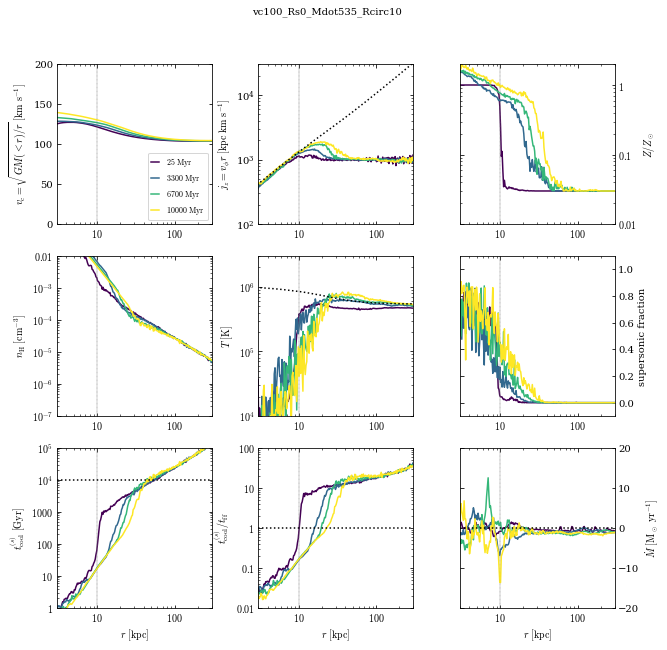

In [6]:
reload(l)
iSnapshots = np.linspace(1,sim.Nsnapshots()-1,4).astype(int)
l.CGM_properties(sim, iSnapshots,Rcirc=10)
pl.savefig(l.figdir+'radial_profiles_%s.pdf'%str(sim))

In [7]:
snapshot = sim.getSnapshot(400)
r = 30
inds = (snapshot.rs() < r*1.1) & (snapshot.rs()>r/1.1)

Text(0, 0.5, '$v_{\\rm phi}\\ [{\\rm km}{\\rm s}^{-1}]$')

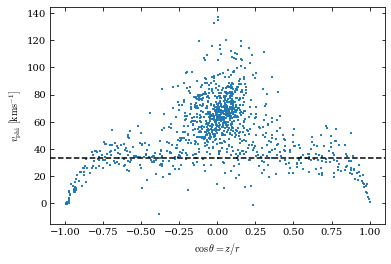

In [10]:
pl.scatter(snapshot.cos_theta()[inds], snapshot.v_phi()[inds],marker=',',s=1)
pl.axhline(1000/r,c='k',ls='--')
pl.xlabel(r'$\cos \theta = z/r$')
pl.ylabel(r'$v_{\rm phi}\ [{\rm km}{\rm s}^{-1}]$')
          